In [ ]:
# Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import \
  (Dense, Dropout, BatchNormalization, Activation)
from tensorflow.keras.callbacks import \
  (ModelCheckpoint, CSVLogger, EarlyStopping,
   LearningRateScheduler)
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import \
  (StandardScaler, OneHotEncoder,
   LabelEncoder, OrdinalEncoder)
from tensorflow.keras import regularizers
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.metrics import \
  (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Read in data
df_cces = pd.read_parquet('CCES_Panel_cleaned.parquet')

In [ ]:
df_cces

,caseid,weight,year,301_1,301_2,301_3,301_4,301_5,301b,302,...,pew_churatd,pew_prayer,pew_religimp,phone,pid3,pid7,race,religpew,union,unionhh
0,25233,0.538062,2010,Yes,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once or twice a month,A few times a week,Somewhat important,Both,Independent,Lean Republican,White,Roman Catholic,Formerly,"No, never"
1,38716,3.470877,2010,Yes,No,Yes,Yes,No,NaN,Stayed about the same,...,Never,Never,Not at all important,Cell only,Democrat,Not very strong Democrat,White,Nothing in particular,"No, never","No, never"
2,7796,0.602477,2010,No,Yes,Yes,Yes,No,Both,Gotten worse,...,More than once a week,Several times a day,Very important,Both,Republican,Strong Republican,White,Mormon,Formerly,Formerly
3,78113,0.264208,2010,Yes,Yes,Yes,Yes,No,Both,Gotten better,...,Never,Never,Not at all important,Cell only,Democrat,Strong Democrat,White,Nothing in particular,"No, never","No, never"
4,63800,0.196632,2010,Yes,Yes,Yes,No,No,Both,Gotten better,...,Seldom,Never,Not too important,Both,Democrat,Strong Democrat,White,Protestant,"No, never","No, never"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28495,57290,1.146715,2014,No,No,No,No,Yes,NaN,Gotten better,...,Never,A few times a month,Somewhat important,Cell only,Democrat,Strong Democrat,Hispanic,Something else,"No, never",Formerly
28496,57315,1.171217,2014,No,No,No,No,Yes,NaN,Stayed about the same,...,A few times a year,A few times a week,Somewhat important,Cell only,Republican,Strong Republican,Hispanic,Roman Catholic,"No, never","No, never"
28497,57399,0.424949,2014,No,Yes,No,No,No,Local Newscast,Gotten much better,...,Never,Seldom,Not at all important,Both,Democrat,Strong Democrat,Hispanic,Something else,"No, never",Formerly
28498,59331,0.505942,2014,No,Yes,No,Yes,No,Local Newscast,Gotten worse,...,Once a week,Once a day,Very important,Cell only,Republican,Strong Republican,Hispanic,Mormon,"Yes, currently","No, never"


In [ ]:
# Sort values to create lagged dv
df_cces = df_cces.sort_values(['caseid', 'year']) \
    .reset_index(drop=True)

In [ ]:
df_cces

,caseid,weight,year,301_1,301_2,301_3,301_4,301_5,301b,302,...,pew_churatd,pew_prayer,pew_religimp,phone,pid3,pid7,race,religpew,union,unionhh
0,1,0.956946,2010,No,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once a week,Once a day,Very important,Both,Republican,Strong Republican,White,Protestant,"No, never","No, never"
1,1,0.956946,2012,No,Yes,Yes,Yes,No,Both,Gotten much worse,...,Once a week,Several times a day,Very important,Cell only,Republican,Strong Republican,White,Protestant,"No, never","No, never"
2,1,0.956946,2014,No,Yes,Yes,Yes,No,National Newscast,Gotten worse,...,Once or twice a month,Several times a day,Very important,Both,Republican,Not very strong Republican,White,Protestant,"No, never","No, never"
3,24,1.847343,2010,Yes,Yes,Yes,No,No,National Newscast,Stayed about the same,...,Never,Never,Not at all important,Both,Republican,Not very strong Republican,White,Agnostic,"No, never","No, never"
4,24,1.847343,2012,Yes,Yes,Yes,No,No,Both,Gotten better,...,Never,Never,Not at all important,Both,Independent,Independent,White,Atheist,"No, never","No, never"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28495,85318,1.747243,2012,No,Yes,Yes,No,No,Both,Gotten better,...,Never,Never,Not at all important,Both,Independent,Independent,White,Something else,"Yes, currently","No, never"
28496,85318,1.747243,2014,No,Yes,No,No,No,NaN,Stayed about the same,...,Never,Never,Not at all important,Both,Independent,Lean Democrat,White,Something else,"No, never","Yes, currently"
28497,85321,0.753324,2010,No,Yes,No,Yes,No,Both,Gotten much worse,...,Seldom,Several times a day,Somewhat important,Both,Republican,Strong Republican,White,Protestant,"No, never","No, never"
28498,85321,0.753324,2012,No,Yes,No,No,No,Both,Gotten much worse,...,Never,Several times a day,Very important,Both,Independent,Lean Republican,White,Protestant,"No, never","No, never"


In [ ]:
# Create lag of the DV
df_cces['VV_primary_lag'] = df_cces.groupby('caseid')['VV_primary'].shift(1)
df_cces['VV_general_lag'] = df_cces.groupby('caseid')['VV_general'].shift(1)

In [ ]:
# Check
df_cces[['caseid', 'year', 'VV_primary_lag', 'VV_primary']]

,caseid,year,VV_primary_lag,VV_primary
0,1,2010,NaN,Voted
1,1,2012,Voted,Voted
2,1,2014,Voted,Voted
3,24,2010,NaN,Voted
4,24,2012,Voted,Voted
...,...,...,...,...
28495,85318,2012,Abstained,Abstained
28496,85318,2014,Abstained,Abstained
28497,85321,2010,NaN,Abstained
28498,85321,2012,Abstained,Abstained


In [ ]:
# Drop all rows where lag is missing = 2010
df_cces = df_cces.query('year != 2010').copy()

In [ ]:
# Convert cdid to category to create dummies for district ID
df_cces['cdid'] = df_cces['cdid'].astype('category')

In [ ]:
# Drop caseid and weight
df_cces = df_cces.drop(['caseid','weight'], axis=1)

In [ ]:
# Select theoretically relevant features
col_select = [
    'year', 'birthyr', 'gender', 'educ', 'race', 'hispanic', 'employ', 'marstat', 'pid7',
    'ideo5', 'child18', 'newsint', 'faminc', 'ownhome', 'milstat_1', 'milstat_3', 'citylength_1',
    'addrlength_1', 'immstat', 'union', 'unionhh', '301_1', '301_2', '301_3', '301_4', '301_5',
    '302', '308b', '309a', '309b', '309c', '309d', '316', '350', '417a_1', '417a_2', '417a_3',
    '417a_4', '417a_5', '417a_6', '418a', '425a', '425b_1', '425b_2', '425b_3', '425b_4',
    'VV_primary', 'VV_general', 'inputstate', 'pew_churatd', 'cdid', 'VV_primary_lag',
    'VV_general_lag'
]
df_cces = df_cces[col_select]

In [ ]:
# Write function to split into training and test set
def split_cces(df):
    df_train = df.query('year == 2012') \
        .drop('year', axis=1)
    df_test = df.query('year == 2014') \
        .drop('year', axis=1)

    return (df_train, df_test)

In [ ]:
# Define class for metrics
class Metrics:

    def __init__(self, conf_matrix):
        """
        Initialize the Metrics object with true labels and predicted labels.
        """
        self.conf_matrix = conf_matrix
        self.TN, self.FP, self.FN, self.TP = self.conf_matrix.ravel()

    def accuracy(self):
        """
        Compute accuracy
        """
        return (self.TP + self.TN) / (self.TP + self.TN + self.FP + self.FN)

    def recall(self):
        """
        Compute recall (sensitivity or TPR)
        """
        return self.TP / (self.TP + self.FN) if (self.TP + self.FN) != 0 else 0

    def specificity(self):
        """
        Computr specificity (TNR)
        """
        return self.TN / (self.TN + self.FP) if (self.TN + self.FP) != 0 else 0

    def precision(self):
        """
        Compute precision
        """
        return self.TP / (self.TP + self.FP) if (self.TP + self.FP) != 0 else 0

    def f1_score(self):
        """
        Compute F1 score
        """
        precision = self.precision()
        recall = self.recall()
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# DV: VV_primary, incl. lag

## Preprocessing

In [ ]:
df_cces_1 = df_cces.drop(['VV_general', 'VV_general_lag'], axis=1)

In [ ]:
df_train, df_test = split_cces(df_cces_1)

In [ ]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [ ]:
X_train = df_train.drop('VV_primary', axis=1)
y_train = df_train['VV_primary'].to_numpy()
X_test = df_test.drop('VV_primary', axis=1)
y_test = df_test['VV_primary'].to_numpy()

In [ ]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [ ]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [ ]:
# One-hot encode only unordered categorical columns
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan),
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [ ]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [ ]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to validation and test features
X_test = pipe.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train.shape[1] # 218 features

218

## Fit

In [ ]:
# Set global seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Define model architecture
model1 = Sequential([
    Dense(32, input_shape=(X_train.shape[1],),
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(16, kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                7008      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                       

In [ ]:
# Set learning rate, loss and metric
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Set checkpoint, logger, early stopping, and learning rate scheduler
checkpoint = ModelCheckpoint('best_model1.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

csv_logger = CSVLogger('training_log1.csv', append=False)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
model1.fit(X_train,
           y_train,
           epochs=50,
           batch_size=16,
           validation_data=(X_test, y_test),
           callbacks=[checkpoint, csv_logger, lr_scheduler],
           shuffle=True)

Epoch 1/50
589/594 [============================>.] - ETA: 0s - loss: 1.0320 - accuracy: 0.5906
Epoch 1: val_loss improved from inf to 0.84909, saving model to best_model1.h5
594/594 [==============================] - 6s 7ms/step - loss: 1.0312 - accuracy: 0.5901 - val_loss: 0.8491 - val_accuracy: 0.6559 - lr: 0.0010
Epoch 2/50
 40/594 [=>............................] - ETA: 1s - loss: 0.8217 - accuracy: 0.6719

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


589/594 [============================>.] - ETA: 0s - loss: 0.7786 - accuracy: 0.6739
Epoch 2: val_loss improved from 0.84909 to 0.73581, saving model to best_model1.h5
594/594 [==============================] - 3s 5ms/step - loss: 0.7783 - accuracy: 0.6734 - val_loss: 0.7358 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 3/50
587/594 [============================>.] - ETA: 0s - loss: 0.6750 - accuracy: 0.7195
Epoch 3: val_loss improved from 0.73581 to 0.70027, saving model to best_model1.h5
594/594 [==============================] - 3s 5ms/step - loss: 0.6760 - accuracy: 0.7196 - val_loss: 0.7003 - val_accuracy: 0.6969 - lr: 0.0010
Epoch 4/50
578/594 [============================>.] - ETA: 0s - loss: 0.6219 - accuracy: 0.7310
Epoch 4: val_loss improved from 0.70027 to 0.68018, saving model to best_model1.h5
594/594 [==============================] - 2s 4ms/step - loss: 0.6226 - accuracy: 0.7299 - val_loss: 0.6802 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 5/50
593/594 [======================

In [ ]:
# Load model with lowest validation loss
best_model1 = tf.keras.models.load_model('best_model1.h5')

In [ ]:
# Test accuracy
test_loss, test_acc = best_model1.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

297/297 [==============================] - 1s 2ms/step - loss: 0.6433 - accuracy: 0.7080
Test Accuracy: 0.7080000042915344


In [ ]:
# Visualize training and validation loss during training process
df_metrics = pd.read_csv('training_log1.csv')

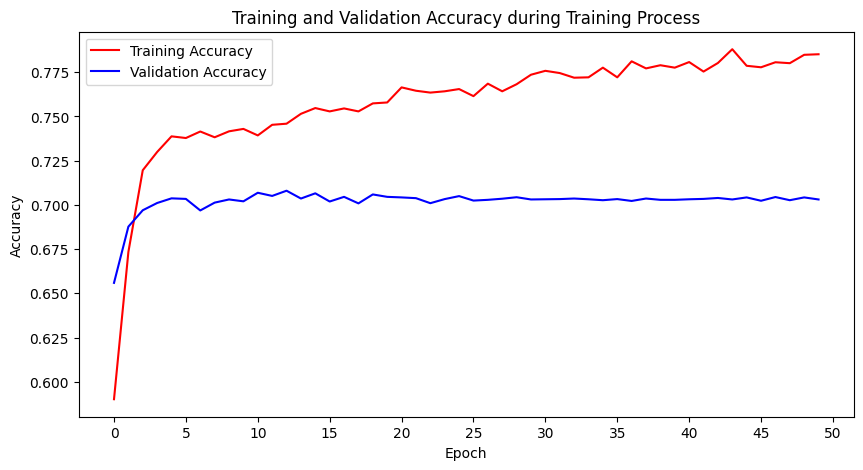

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_metrics['epoch'], df_metrics['accuracy'],
         label='Training Accuracy', color='red')
plt.plot(df_metrics['epoch'], df_metrics['val_accuracy'],
         label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy during Training Process')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.linspace(0, 50, 11).astype(int))
plt.legend()
plt.show()

## Evaluate

In [ ]:
preds_proba_train = best_model1.predict(X_train).flatten()
preds_train = (preds_proba_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.3f}')

297/297 [==============================] - 1s 2ms/step
Training accuracy: 0.780


In [ ]:
preds_proba_test = best_model1.predict(X_test).flatten()
preds_test = (preds_proba_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.3f}')

297/297 [==============================] - 0s 2ms/step
Test accuracy: 0.708


In [ ]:
cmat = confusion_matrix(y_true=y_test, y_pred=preds_test)
cmat_disp = ConfusionMatrixDisplay(cmat, display_labels=y_encoder.classes_)

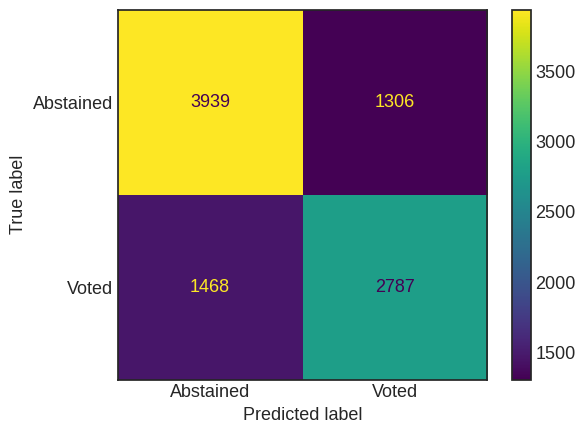

In [ ]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat_disp.plot();

In [ ]:
# Additional metrics for performance on test data
metrics = Metrics(cmat)
print(f'Accuracy: {metrics.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics.recall():.2%}')
print(f'Specificity (TNR): {metrics.specificity():.2%}')
print(f'Precision: {metrics.precision():.2%}')
print(f'F1: {metrics.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba_test):.2f}')

Accuracy: 70.80%
Sensitivity/Recall (TPR): 65.50%
Specificity (TNR): 75.10%
Precision: 68.09%
F1: 0.67
AUC: 0.75


# DV: VV_primary, excl. lag

In [ ]:
df_cces_2 = df_cces.drop(['VV_general', 'VV_general_lag', 'VV_primary_lag'], axis=1)

In [ ]:
df_train, df_test = split_cces(df_cces_2)

In [ ]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [ ]:
X_train = df_train.drop('VV_primary', axis=1)
y_train = df_train['VV_primary'].to_numpy()
X_test = df_test.drop('VV_primary', axis=1)
y_test = df_test['VV_primary'].to_numpy()

In [ ]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [ ]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [ ]:
# One-hot encode only unordered categorical columns
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan),
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [ ]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [ ]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to validation and test features
X_test = pipe.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Check shape
X_train.shape[1] # 217 features

217

## Fit

In [ ]:
# Set global seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Define model architecture
model2 = Sequential([
    Dense(32, input_shape=(X_train.shape[1],),
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(16, kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                6976      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 activation_3 (Activation)   (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_3 (Bat  (None, 16)                64        
 chNormalization)                                     

In [ ]:
# Set learning rate, loss and metric
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Set checkpoint, logger, early stopping, and learning rate scheduler
checkpoint = ModelCheckpoint('best_model2.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

csv_logger = CSVLogger('training_log2.csv', append=False)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
model2.fit(X_train,
           y_train,
           epochs=50,
           batch_size=32,
           validation_data=(X_test, y_test),
           callbacks=[checkpoint, csv_logger, lr_scheduler])

Epoch 1/50
293/297 [============================>.] - ETA: 0s - loss: 1.0953 - accuracy: 0.5675
Epoch 1: val_loss improved from inf to 0.92211, saving model to best_model2.h5
297/297 [==============================] - 3s 5ms/step - loss: 1.0941 - accuracy: 0.5669 - val_loss: 0.9221 - val_accuracy: 0.6242 - lr: 0.0010
Epoch 2/50
 60/297 [=====>........................] - ETA: 0s - loss: 0.9165 - accuracy: 0.6318

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


290/297 [============================>.] - ETA: 0s - loss: 0.8755 - accuracy: 0.6290
Epoch 2: val_loss improved from 0.92211 to 0.80821, saving model to best_model2.h5
297/297 [==============================] - 1s 4ms/step - loss: 0.8743 - accuracy: 0.6284 - val_loss: 0.8082 - val_accuracy: 0.6496 - lr: 0.0010
Epoch 3/50
287/297 [===========================>..] - ETA: 0s - loss: 0.7636 - accuracy: 0.6588
Epoch 3: val_loss improved from 0.80821 to 0.74299, saving model to best_model2.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.7631 - accuracy: 0.6585 - val_loss: 0.7430 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 4/50
291/297 [============================>.] - ETA: 0s - loss: 0.6939 - accuracy: 0.6813
Epoch 4: val_loss improved from 0.74299 to 0.70829, saving model to best_model2.h5
297/297 [==============================] - 3s 9ms/step - loss: 0.6945 - accuracy: 0.6799 - val_loss: 0.7083 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 5/50
288/297 [======================

In [ ]:
# Load model with lowest validation loss
best_model2 = tf.keras.models.load_model('best_model2.h5')

In [ ]:
# Test accuracy
test_loss, test_acc = best_model2.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

297/297 [==============================] - 1s 2ms/step - loss: 0.6561 - accuracy: 0.6674
Test Accuracy: 0.6673684120178223


In [ ]:
# Visualize training and validation loss during training process
df_metrics = pd.read_csv('training_log2.csv')

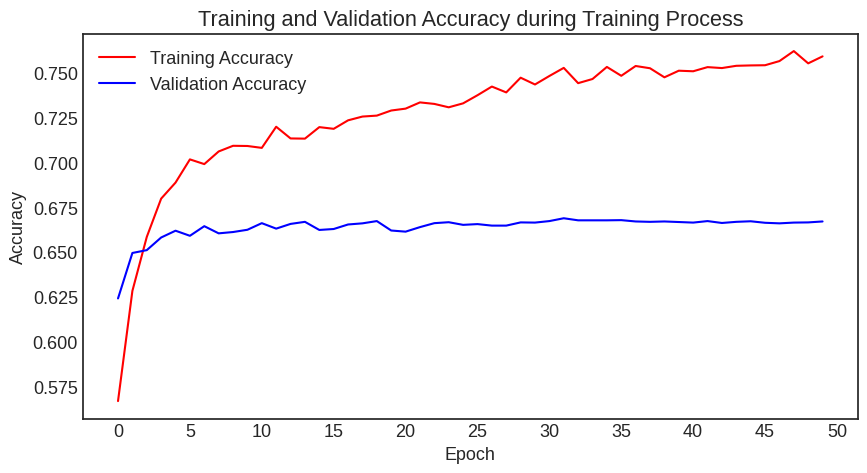

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_metrics['epoch'], df_metrics['accuracy'],
         label='Training Accuracy', color='red')
plt.plot(df_metrics['epoch'], df_metrics['val_accuracy'],
         label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy during Training Process')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.linspace(0, 50, 11).astype(int))
plt.legend()
plt.show()

## Evaluate

In [ ]:
preds_proba_train = best_model2.predict(X_train).flatten()
preds_train = (preds_proba_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.3f}')

297/297 [==============================] - 1s 3ms/step
Training accuracy: 0.758


In [ ]:
preds_proba_test = best_model2.predict(X_test).flatten()
preds_test = (preds_proba_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.3f}')

297/297 [==============================] - 1s 3ms/step
Test accuracy: 0.667


In [ ]:
cmat = confusion_matrix(y_true=y_test, y_pred=preds_test)
cmat_disp = ConfusionMatrixDisplay(cmat, display_labels=y_encoder.classes_)

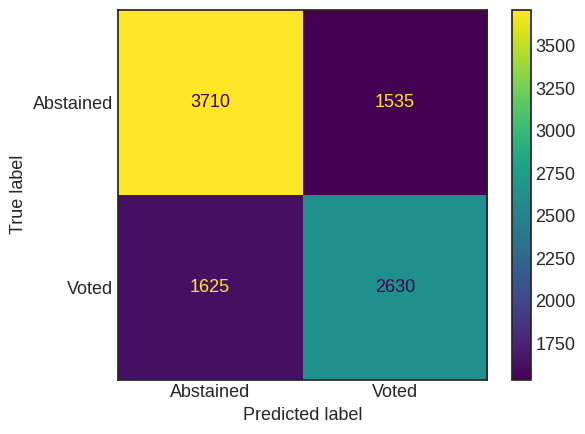

In [ ]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat_disp.plot();

In [ ]:
# Additional metrics for performance on test data
metrics = Metrics(cmat)
print(f'Accuracy: {metrics.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics.recall():.2%}')
print(f'Specificity (TNR): {metrics.specificity():.2%}')
print(f'Precision: {metrics.precision():.2%}')
print(f'F1: {metrics.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba_test):.2f}')

Accuracy: 66.74%
Sensitivity/Recall (TPR): 61.81%
Specificity (TNR): 70.73%
Precision: 63.15%
F1: 0.62
AUC: 0.72


# DV: VV_general, incl. lag

## Preprocessing

In [ ]:
df_cces_3 = df_cces.drop(['VV_primary', 'VV_primary_lag'], axis=1)

In [ ]:
df_train, df_test = split_cces(df_cces_3)

In [ ]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [ ]:
X_train = df_train.drop('VV_general', axis=1)
y_train = df_train['VV_general'].to_numpy()
X_test = df_test.drop('VV_general', axis=1)
y_test = df_test['VV_general'].to_numpy()

In [ ]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [ ]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [ ]:
# One-hot encode only unordered categorical columns
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan),
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [ ]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [ ]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to validation and test features
X_test = pipe.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Check shape
X_train.shape[1] # 218 features

218

## Fit – No adjustment for class imbalance

In [ ]:
# Set global seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Define model architecture
model3 = Sequential([
    Dense(32, input_shape=(X_train.shape[1],),
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(16, kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                7008      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_5 (Bat  (None, 16)                64        
 chNormalization)                                     

In [ ]:
# Set learning rate, loss and metric
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Set checkpoint, logger, and learning rate scheduler
checkpoint = ModelCheckpoint('best_model3.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

csv_logger = CSVLogger('training_log3.csv', append=False)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
model3.fit(X_train,
           y_train,
           epochs=50,
           batch_size=32,
           validation_data=(X_test, y_test),
           callbacks=[checkpoint, csv_logger, lr_scheduler])

Epoch 1/50
284/297 [===========================>..] - ETA: 0s - loss: 0.8161 - accuracy: 0.5816
Epoch 1: val_loss improved from inf to 0.64564, saving model to best_model3.h5
297/297 [==============================] - 3s 5ms/step - loss: 0.8099 - accuracy: 0.5882 - val_loss: 0.6456 - val_accuracy: 0.7537 - lr: 0.0010
Epoch 2/50
 39/297 [==>...........................] - ETA: 0s - loss: 0.6778 - accuracy: 0.7115

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


287/297 [===========================>..] - ETA: 0s - loss: 0.6620 - accuracy: 0.7283
Epoch 2: val_loss improved from 0.64564 to 0.61426, saving model to best_model3.h5
297/297 [==============================] - 1s 5ms/step - loss: 0.6597 - accuracy: 0.7303 - val_loss: 0.6143 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 3/50
296/297 [============================>.] - ETA: 0s - loss: 0.6146 - accuracy: 0.7539
Epoch 3: val_loss improved from 0.61426 to 0.59908, saving model to best_model3.h5
297/297 [==============================] - 2s 5ms/step - loss: 0.6143 - accuracy: 0.7540 - val_loss: 0.5991 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 4/50
293/297 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.7647
Epoch 4: val_loss improved from 0.59908 to 0.58407, saving model to best_model3.h5
297/297 [==============================] - 1s 4ms/step - loss: 0.5893 - accuracy: 0.7639 - val_loss: 0.5841 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 5/50
285/297 [======================

In [ ]:
# Load model with lowest validation loss
best_model3 = tf.keras.models.load_model('best_model3.h5')

In [ ]:
# Test accuracy
test_loss, test_acc = best_model3.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

297/297 [==============================] - 1s 2ms/step - loss: 0.5505 - accuracy: 0.7686
Test Accuracy: 0.7686315774917603


In [ ]:
# Visualize training and validation loss during training process
df_metrics = pd.read_csv('training_log3.csv')

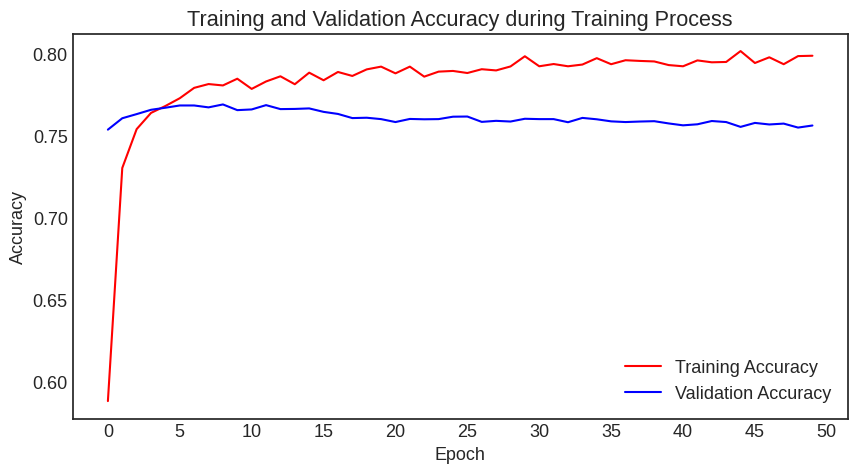

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_metrics['epoch'], df_metrics['accuracy'],
         label='Training Accuracy', color='red')
plt.plot(df_metrics['epoch'], df_metrics['val_accuracy'],
         label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy during Training Process')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.linspace(0, 50, 11).astype(int))
plt.legend()
plt.show()

## Evaluate

In [ ]:
preds_proba_train = best_model3.predict(X_train).flatten()
preds_train = (preds_proba_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.3f}')

297/297 [==============================] - 1s 1ms/step
Training accuracy: 0.799


In [ ]:
preds_proba_test = best_model3.predict(X_test).flatten()
preds_test = (preds_proba_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.3f}')

297/297 [==============================] - 0s 1ms/step
Test accuracy: 0.769


## Fit – Class weights

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

In [ ]:
# Set global seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Define model architecture
model4 = Sequential([
    Dense(32, input_shape=(X_train.shape[1],),
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(16, kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                7008      
                                                                 
 batch_normalization_6 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 32)                0         
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 batch_normalization_7 (Bat  (None, 16)                64        
 chNormalization)                                     

In [ ]:
# Set learning rate, loss and metric
model4.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Set checkpoint, logger, and learning rate scheduler
checkpoint = ModelCheckpoint('best_model4.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

csv_logger = CSVLogger('training_log4.csv', append=False)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
model4.fit(X_train,
           y_train,
           epochs=50,
           batch_size=16,
           validation_data=(X_test, y_test),
           callbacks=[checkpoint, csv_logger, lr_scheduler],
           class_weight=class_weight_dict)

Epoch 1/50
579/594 [============================>.] - ETA: 0s - loss: 0.8239 - accuracy: 0.5047
Epoch 1: val_loss improved from inf to 0.71541, saving model to best_model4.h5
594/594 [==============================] - 4s 5ms/step - loss: 0.8218 - accuracy: 0.5066 - val_loss: 0.7154 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 2/50
 30/594 [>.............................] - ETA: 2s - loss: 0.7470 - accuracy: 0.5875

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


581/594 [============================>.] - ETA: 0s - loss: 0.7360 - accuracy: 0.6050
Epoch 2: val_loss improved from 0.71541 to 0.68564, saving model to best_model4.h5
594/594 [==============================] - 3s 6ms/step - loss: 0.7340 - accuracy: 0.6063 - val_loss: 0.6856 - val_accuracy: 0.7026 - lr: 0.0010
Epoch 3/50
591/594 [============================>.] - ETA: 0s - loss: 0.6985 - accuracy: 0.6686
Epoch 3: val_loss improved from 0.68564 to 0.66197, saving model to best_model4.h5
594/594 [==============================] - 2s 4ms/step - loss: 0.6983 - accuracy: 0.6689 - val_loss: 0.6620 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 4/50
582/594 [============================>.] - ETA: 0s - loss: 0.6780 - accuracy: 0.7007
Epoch 4: val_loss improved from 0.66197 to 0.65738, saving model to best_model4.h5
594/594 [==============================] - 3s 5ms/step - loss: 0.6783 - accuracy: 0.7005 - val_loss: 0.6574 - val_accuracy: 0.7172 - lr: 0.0010
Epoch 5/50
583/594 [======================

In [ ]:
# Load model with lowest validation loss
best_model4 = tf.keras.models.load_model('best_model4.h5')

In [ ]:
# Test accuracy
test_loss, test_acc = best_model4.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

297/297 [==============================] - 1s 2ms/step - loss: 0.6249 - accuracy: 0.7044
Test Accuracy: 0.7044210433959961


In [ ]:
# Visualize training and validation loss during training process
df_metrics = pd.read_csv('training_log4.csv')

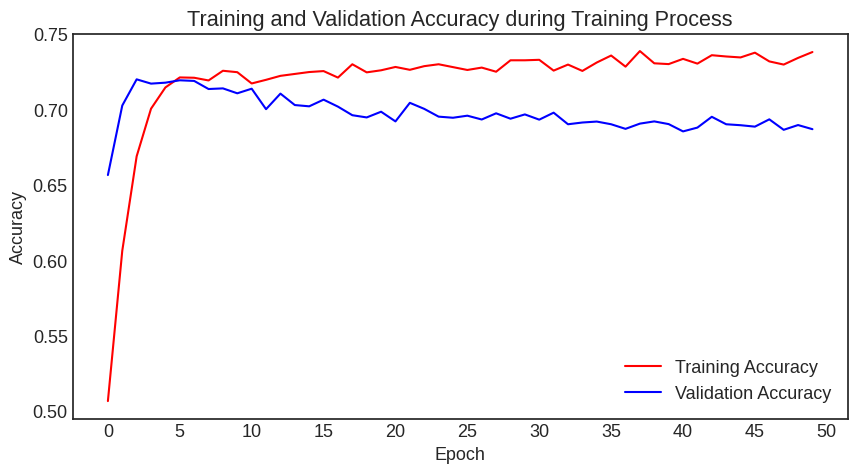

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_metrics['epoch'], df_metrics['accuracy'],
         label='Training Accuracy', color='red')
plt.plot(df_metrics['epoch'], df_metrics['val_accuracy'],
         label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy during Training Process')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.linspace(0, 50, 11).astype(int))
plt.legend()
plt.show()

## Evaluate

In [ ]:
preds_proba_train = best_model4.predict(X_train).flatten()
preds_train = (preds_proba_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.3f}')

297/297 [==============================] - 1s 1ms/step
Training accuracy: 0.778


In [ ]:
preds_proba_test = best_model4.predict(X_test).flatten()
preds_test = (preds_proba_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.3f}')

297/297 [==============================] - 0s 1ms/step
Test accuracy: 0.704


In [ ]:
cmat = confusion_matrix(y_true=y_test, y_pred=preds_test)
cmat_disp = ConfusionMatrixDisplay(cmat, display_labels=y_encoder.classes_)

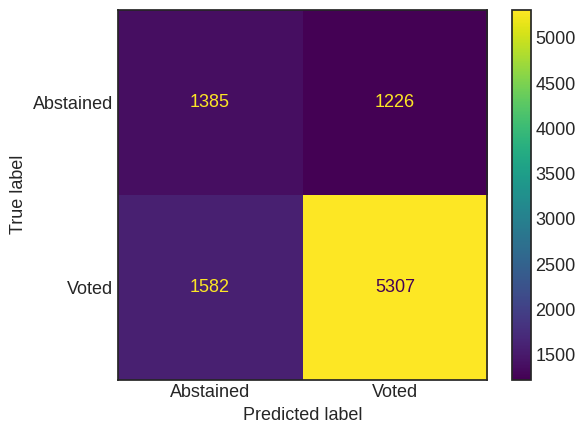

In [ ]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat_disp.plot();

In [ ]:
# Additional metrics for performance on test data
metrics = Metrics(cmat)
print(f'Accuracy: {metrics.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics.recall():.2%}')
print(f'Specificity (TNR): {metrics.specificity():.2%}')
print(f'Precision: {metrics.precision():.2%}')
print(f'F1: {metrics.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba_test):.2f}')

Accuracy: 70.44%
Sensitivity/Recall (TPR): 77.04%
Specificity (TNR): 53.04%
Precision: 81.23%
F1: 0.79
AUC: 0.69


# DV: VV_general, excl. lag

## Preprocessing

In [ ]:
df_cces_4 = df_cces.drop(['VV_primary', 'VV_primary_lag', 'VV_general_lag'], axis=1)

In [ ]:
df_train, df_test = split_cces(df_cces_4)

In [ ]:
# Number of samples per split
print(f'# Training samples: {len(df_train)} \
        # Test samples: {len(df_test)}')

# Training samples: 9500         # Test samples: 9500


In [ ]:
X_train = df_train.drop('VV_general', axis=1)
y_train = df_train['VV_general'].to_numpy()
X_test = df_test.drop('VV_general', axis=1)
y_test = df_test['VV_general'].to_numpy()

In [ ]:
# Encode targets
y_encoder = LabelEncoder()

y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

In [ ]:
# Identify ordered categorical columns
ordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and df_cces[col].cat.ordered]
# Identify unordered cateforical columns
unordered_cat_cols = [col for col in X_train.columns if pd.api.types.is_categorical_dtype(df_cces[col]) and not df_cces[col].cat.ordered]
# Define dictionary for category order
category_order = {col: list(X_train[col].cat.categories) for col in ordered_cat_cols}

In [ ]:
# One-hot encode only unordered categorical columns
col_trans = ColumnTransformer(
    [(col,
      OneHotEncoder(drop='first',
                    sparse_output=False,
                    handle_unknown='ignore'),
     [col]) for col in unordered_cat_cols] +
    [(col,
      OrdinalEncoder(categories=[category_order[col]],
                     handle_unknown='use_encoded_value',
                     unknown_value=np.nan),
      [col]) for col in ordered_cat_cols],
    remainder='passthrough'
)

# Impute missing values
knn_imputer = KNNImputer(missing_values=np.nan,
                         n_neighbors=13,
                         weights='distance')

# Scaling
scaler = StandardScaler(with_mean=True,
                        with_std=True)

In [ ]:
# Define pipeline
pipe = Pipeline(steps=[('col_trans', col_trans),
                       ('knn_imputer', knn_imputer),
                       ('scaler', scaler)]).set_output(transform='pandas')

In [ ]:
# Fit and apply pipe to training features
X_train = pipe.fit_transform(X_train)
# Apply pipe to validation and test features
X_test = pipe.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Check shape
X_train.shape[1] # 217 features

217

## Fit – No adjustment for class imbalance

In [ ]:
# Set global seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Define model architecture
model5 = Sequential([
    Dense(64, input_shape=(X_train.shape[1],),
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

In [ ]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                13952     
                                                                 
 batch_normalization_8 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 64)                0         
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_9 (Bat  (None, 32)                128       
 chNormalization)                                     

In [ ]:
# Set learning rate, loss and metric
model5.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Set checkpoint, logger, and learning rate scheduler
checkpoint = ModelCheckpoint('best_model5.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

csv_logger = CSVLogger('training_log5.csv', append=False)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
model5.fit(X_train,
           y_train,
           epochs=50,
           batch_size=16,
           validation_data=(X_test, y_test),
           callbacks=[checkpoint, csv_logger, lr_scheduler])

Epoch 1/50
591/594 [============================>.] - ETA: 0s - loss: 0.7913 - accuracy: 0.6949
Epoch 1: val_loss improved from inf to 0.69520, saving model to best_model5.h5
594/594 [==============================] - 5s 5ms/step - loss: 0.7911 - accuracy: 0.6952 - val_loss: 0.6952 - val_accuracy: 0.7596 - lr: 0.0010
Epoch 2/50
 44/594 [=>............................] - ETA: 1s - loss: 0.6883 - accuracy: 0.7557

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


590/594 [============================>.] - ETA: 0s - loss: 0.6868 - accuracy: 0.7553
Epoch 2: val_loss improved from 0.69520 to 0.65612, saving model to best_model5.h5
594/594 [==============================] - 3s 5ms/step - loss: 0.6871 - accuracy: 0.7553 - val_loss: 0.6561 - val_accuracy: 0.7644 - lr: 0.0010
Epoch 3/50
583/594 [============================>.] - ETA: 0s - loss: 0.6344 - accuracy: 0.7657
Epoch 3: val_loss improved from 0.65612 to 0.63423, saving model to best_model5.h5
594/594 [==============================] - 3s 6ms/step - loss: 0.6346 - accuracy: 0.7656 - val_loss: 0.6342 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 4/50
574/594 [===========================>..] - ETA: 0s - loss: 0.6076 - accuracy: 0.7712
Epoch 4: val_loss improved from 0.63423 to 0.61608, saving model to best_model5.h5
594/594 [==============================] - 2s 4ms/step - loss: 0.6092 - accuracy: 0.7701 - val_loss: 0.6161 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 5/50
591/594 [======================

In [ ]:
# Load model with lowest validation loss
best_model5 = tf.keras.models.load_model('best_model5.h5')

In [ ]:
# Test accuracy
test_loss, test_acc = best_model5.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

297/297 [==============================] - 1s 2ms/step - loss: 0.5670 - accuracy: 0.7632
Test Accuracy: 0.7631579041481018


In [ ]:
# Visualize training and validation loss during training process
df_metrics = pd.read_csv('training_log5.csv')

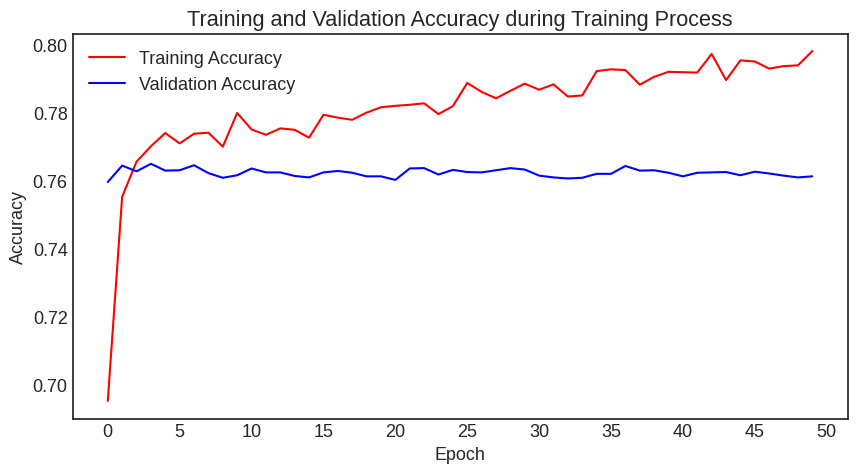

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_metrics['epoch'], df_metrics['accuracy'],
         label='Training Accuracy', color='red')
plt.plot(df_metrics['epoch'], df_metrics['val_accuracy'],
         label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy during Training Process')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.linspace(0, 50, 11).astype(int))
plt.legend()
plt.show()

## Evaluate

In [ ]:
preds_proba_train = best_model5.predict(X_train).flatten()
preds_train = (preds_proba_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.3f}')

297/297 [==============================] - 1s 2ms/step
Training accuracy: 0.796


In [ ]:
preds_proba_test = best_model5.predict(X_test).flatten()
preds_test = (preds_proba_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.3f}')

297/297 [==============================] - 1s 2ms/step
Test accuracy: 0.763


## Fit – Class weights

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}

In [ ]:
# Set global seed
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Define model architecture
model6 = Sequential([
    Dense(64, input_shape=(X_train.shape[1],),
          kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(32, kernel_initializer='he_normal',
          kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
])

In [ ]:
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                13952     
                                                                 
 batch_normalization_10 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 64)                0         
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_11 (Ba  (None, 32)                128       
 tchNormalization)                                    

In [ ]:
# Set learning rate, loss and metric
model6.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Set checkpoint, logger, and learning rate scheduler
checkpoint = ModelCheckpoint('best_model6.h5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

csv_logger = CSVLogger('training_log6.csv', append=False)

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
model6.fit(X_train,
           y_train,
           epochs=50,
           batch_size=16,
           validation_data=(X_test, y_test),
           callbacks=[checkpoint, csv_logger, lr_scheduler],
           class_weight=class_weight_dict)

Epoch 1/50
578/594 [============================>.] - ETA: 0s - loss: 0.8987 - accuracy: 0.5536
Epoch 1: val_loss improved from inf to 0.80815, saving model to best_model6.h5
594/594 [==============================] - 5s 5ms/step - loss: 0.8982 - accuracy: 0.5535 - val_loss: 0.8081 - val_accuracy: 0.6299 - lr: 0.0010
Epoch 2/50
 60/594 [==>...........................] - ETA: 1s - loss: 0.8359 - accuracy: 0.6177

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


580/594 [============================>.] - ETA: 0s - loss: 0.8083 - accuracy: 0.6087
Epoch 2: val_loss improved from 0.80815 to 0.76053, saving model to best_model6.h5
594/594 [==============================] - 3s 5ms/step - loss: 0.8079 - accuracy: 0.6100 - val_loss: 0.7605 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 3/50
579/594 [============================>.] - ETA: 0s - loss: 0.7585 - accuracy: 0.6536
Epoch 3: val_loss improved from 0.76053 to 0.72394, saving model to best_model6.h5
594/594 [==============================] - 3s 4ms/step - loss: 0.7583 - accuracy: 0.6526 - val_loss: 0.7239 - val_accuracy: 0.6874 - lr: 0.0010
Epoch 4/50
588/594 [============================>.] - ETA: 0s - loss: 0.7306 - accuracy: 0.6745
Epoch 4: val_loss improved from 0.72394 to 0.71279, saving model to best_model6.h5
594/594 [==============================] - 4s 6ms/step - loss: 0.7316 - accuracy: 0.6737 - val_loss: 0.7128 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 5/50
589/594 [======================

In [ ]:
# Load model with lowest validation loss
best_model6 = tf.keras.models.load_model('best_model6.h5')

In [ ]:
# Test accuracy
test_loss, test_acc = best_model6.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

297/297 [==============================] - 1s 2ms/step - loss: 0.6423 - accuracy: 0.6647
Test Accuracy: 0.6647368669509888


In [ ]:
# Visualize training and validation loss during training process
df_metrics = pd.read_csv('training_log6.csv')

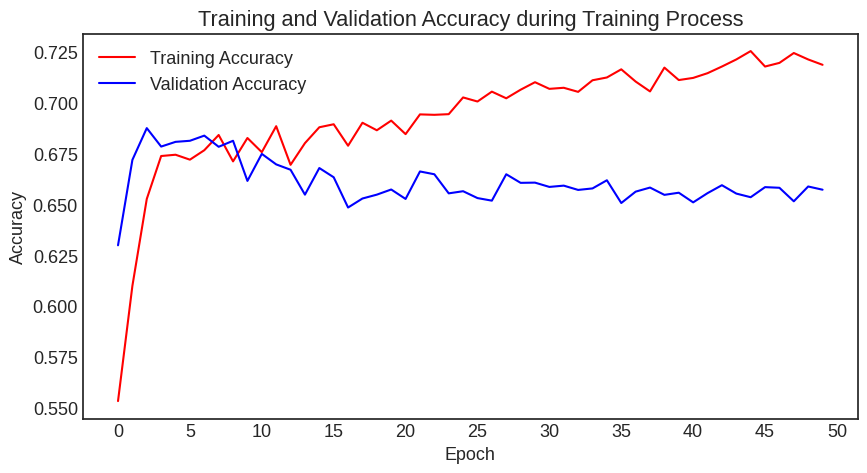

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_metrics['epoch'], df_metrics['accuracy'],
         label='Training Accuracy', color='red')
plt.plot(df_metrics['epoch'], df_metrics['val_accuracy'],
         label='Validation Accuracy', color='blue')
plt.title('Training and Validation Accuracy during Training Process')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.linspace(0, 50, 11).astype(int))
plt.legend()
plt.show()

## Evaluate

In [ ]:
preds_proba_train = best_model6.predict(X_train).flatten()
preds_train = (preds_proba_train > .5).astype(int)
print(f'Training accuracy: {np.sum(preds_train == y_train)/len(y_train):.3f}')

297/297 [==============================] - 1s 1ms/step
Training accuracy: 0.769


In [ ]:
preds_proba_test = best_model6.predict(X_test).flatten()
preds_test = (preds_proba_test > .5).astype(int)
print(f'Test accuracy: {np.sum(preds_test == y_test)/len(y_test):.3f}')

297/297 [==============================] - 0s 1ms/step
Test accuracy: 0.665


In [ ]:
cmat = confusion_matrix(y_true=y_test, y_pred=preds_test)
cmat_disp = ConfusionMatrixDisplay(cmat, display_labels=y_encoder.classes_)

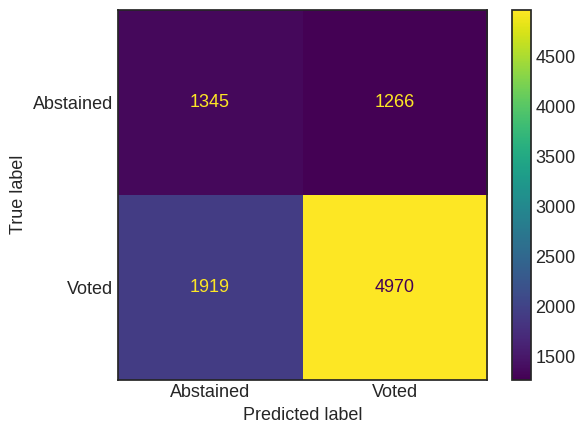

In [ ]:
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 13
cmat_disp.plot();

In [ ]:
# Additional metrics for performance on test data
metrics = Metrics(cmat)
print(f'Accuracy: {metrics.accuracy():.2%}')
print(f'Sensitivity/Recall (TPR): {metrics.recall():.2%}')
print(f'Specificity (TNR): {metrics.specificity():.2%}')
print(f'Precision: {metrics.precision():.2%}')
print(f'F1: {metrics.f1_score():.2f}')
print(f'AUC: {roc_auc_score(y_test, preds_proba_test):.2f}')

Accuracy: 66.47%
Sensitivity/Recall (TPR): 72.14%
Specificity (TNR): 51.51%
Precision: 79.70%
F1: 0.76
AUC: 0.66
